2025-06-05 01:53:25.014701: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749088405.216637      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749088405.269619      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


Epoch 1/4
Training Loss: 0.900115084189635
Training Accuracy: 0.5098039215686274
Training Precision: 0.48717948717948717
Training Recall: 0.3877551020408163
Training F1-score: 0.43181818181818177
Time taken for epoch 1: 281.84 seconds
Epoch 2/4
Training Loss: 0.6099178997369913
Training Accuracy: 0.6470588235294118
Training Precision: 0.6
Training Recall: 0.7959183673469388
Training F1-score: 0.6842105263157895
Time taken for epoch 2: 272.96 seconds
Epoch 3/4
Training Loss: 0.4375842431416878
Training Accuracy: 0.8627450980392157
Training Precision: 0.8431372549019608
Training Recall: 0.8775510204081632
Training F1-score: 0.86
Time taken for epoch 3: 265.60 seconds
Epoch 4/4
Training Loss: 0.28537864925769657
Training Accuracy: 0.9509803921568627
Training Precision: 0.94
Training Recall: 0.9591836734693877
Training F1-score: 0.9494949494949495
Time taken for epoch 4: 263.95 seconds
Total training time: 1084.36 seconds
Accuracy: 0.5882352941176471
Precision: 0.5882352941176471
Recall: 0

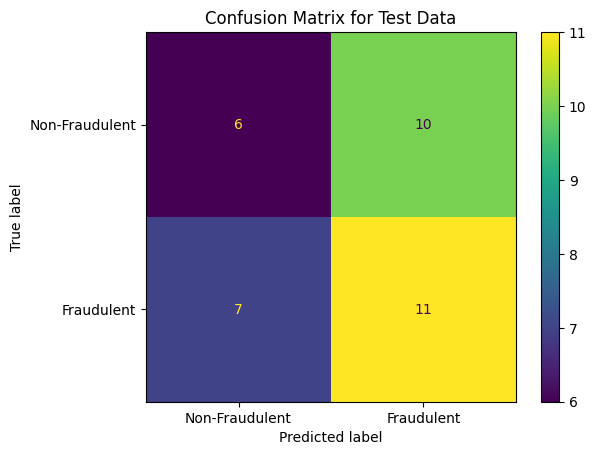

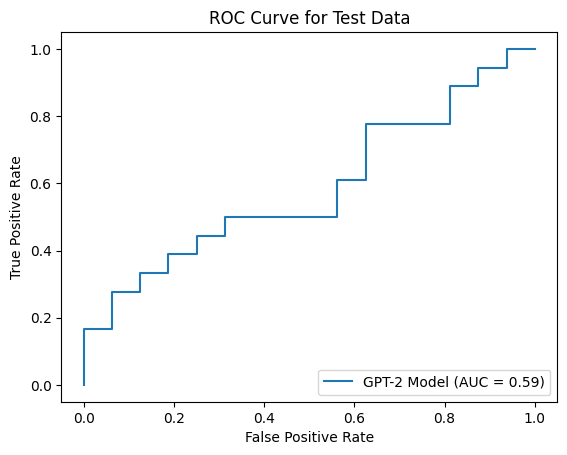

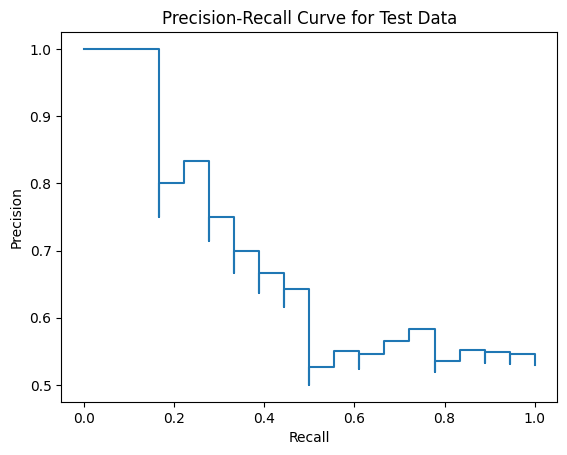

(0.5, 0.4945054945054945, 0.5, 0.49336870026525204)

In [1]:
import pandas as pd
from transformers import GPT2Tokenizer, GPT2ForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import time
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay
import numpy as np

file_path = '/kaggle/input/financial-statement-fraud-data/Final_Dataset.csv' 
dataset = pd.read_csv(file_path)

## Preprocessing the data

# Encode Labels
label_encoder = LabelEncoder()
dataset['Fraud'] = label_encoder.fit_transform(dataset['Fraud'])

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
# Check if padding token is set, if not, set it
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})

#tokenizer.pad_token = tokenizer.eos_token



text_data = dataset['Fillings'].tolist()
encoded_inputs = tokenizer(text_data, padding='max_length', truncation=True, max_length=512, return_tensors="pt")
attention_masks = encoded_inputs['attention_mask']

# Split into Training, Validation, and Test Sets
train_inputs, temp_inputs, train_labels, temp_labels, train_masks, temp_masks = train_test_split(
    encoded_inputs['input_ids'], dataset['Fraud'], attention_masks, test_size=0.4, random_state=42
)

val_inputs, test_inputs, val_labels, test_labels, val_masks, test_masks = train_test_split(
    temp_inputs, temp_labels, temp_masks, test_size=0.5, random_state=42
)

# Create DataLoader with attention masks
train_dataset = TensorDataset(train_inputs, train_masks, torch.tensor(train_labels.values).long())
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)

val_dataset = TensorDataset(val_inputs, val_masks, torch.tensor(val_labels.values).long())
val_dataloader = DataLoader(val_dataset, batch_size=8)

test_dataset = TensorDataset(test_inputs, test_masks, torch.tensor(test_labels.values).long())
test_dataloader = DataLoader(test_dataset, batch_size=8)

# Load GPT-2 Model for Sequence Classification
model = GPT2ForSequenceClassification.from_pretrained('gpt2', num_labels=2)
model.resize_token_embeddings(len(tokenizer) + 1)
model.config.pad_token_id = tokenizer.pad_token_id
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)

# Training Loop with attention masks
num_epochs = 4
total_start_time = time.time()

for epoch in range(num_epochs):
    start_time = time.time()
    model.train()
    train_loss = 0
    train_predictions = []
    train_true_labels = []

    for batch in train_dataloader:
        inputs, masks, labels = batch
        optimizer.zero_grad()
        outputs = model(inputs, attention_mask=masks, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        logits = outputs.logits
        predictions = torch.argmax(F.softmax(logits, dim=1), dim=1)
        train_predictions.extend(predictions.tolist())
        train_true_labels.extend(labels.tolist())
    
    # Training Metrics
    train_accuracy = accuracy_score(train_true_labels, train_predictions)
    train_precision = precision_score(train_true_labels, train_predictions)
    train_recall = recall_score(train_true_labels, train_predictions)
    train_f1 = f1_score(train_true_labels, train_predictions)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Training Loss: {train_loss/len(train_dataloader)}")
    print(f"Training Accuracy: {train_accuracy}")
    print(f"Training Precision: {train_precision}")
    print(f"Training Recall: {train_recall}")
    print(f"Training F1-score: {train_f1}")

    # Validation Loop
    model.eval()
    val_predictions = []
    val_true_labels = []
    with torch.no_grad():
        for batch in val_dataloader:
            inputs, masks, labels = batch
            outputs = model(inputs, attention_mask=masks)
            logits = outputs.logits
            predictions = torch.argmax(F.softmax(logits, dim=1), dim=1)
            val_predictions.extend(predictions.tolist())
            val_true_labels.extend(labels.tolist())
    
    end_time = time.time()
    epoch_time = end_time - start_time
    print(f"Time taken for epoch {epoch+1}: {epoch_time:.2f} seconds")

total_end_time = time.time()
total_time = total_end_time - total_start_time
print(f"Total training time: {total_time:.2f} seconds")


def evaluate(model, dataloader):
    model.eval()
    predictions, true_labels = [], []

    with torch.no_grad():
        for batch in dataloader:
            inputs, masks, labels = batch
            outputs = model(inputs, attention_mask=masks)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)
            predictions.extend(preds.tolist())
            true_labels.extend(labels.tolist())

    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions, average='weighted')
    recall = recall_score(true_labels, predictions, average='weighted')
    f1 = f1_score(true_labels, predictions, average='weighted')

    print(f'Accuracy: {accuracy}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1 Score: {f1}')

    return accuracy, precision, recall, f1

evaluate(model, val_dataloader)

def plot_graphs(true_labels, predictions, probas=None):
    # 1. Plot the Confusion Matrix
    cm = confusion_matrix(true_labels, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-Fraudulent", "Fraudulent"])
    disp.plot()
    plt.title('Confusion Matrix for Test Data')
    plt.show()

    if probas is not None:
        # 2. Plot the ROC Curve
        fpr, tpr, _ = roc_curve(true_labels, probas[:, 1])
        roc_auc = auc(fpr, tpr)
        roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='GPT-2 Model')
        roc_display.plot()
        plt.title('ROC Curve for Test Data')
        plt.show()

        # 3. Plot the Precision-Recall Curve
        precision_curve, recall_curve, _ = precision_recall_curve(true_labels, probas[:, 1])
        pr_display = PrecisionRecallDisplay(precision=precision_curve, recall=recall_curve)
        pr_display.plot()
        plt.title('Precision-Recall Curve for Test Data')
        plt.show()

def evaluate_and_plot(model, dataloader):
    model.eval()
    predictions, true_labels, probabilities = [], [], []

    with torch.no_grad():
        for batch in dataloader:
            inputs, masks, labels = batch
            outputs = model(inputs, attention_mask=masks)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)
            probabilities.extend(F.softmax(logits, dim=1).tolist())
            predictions.extend(preds.tolist())
            true_labels.extend(labels.tolist())

    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions, average='weighted')
    recall = recall_score(true_labels, predictions, average='weighted')
    f1 = f1_score(true_labels, predictions, average='weighted')

    print(f'Accuracy: {accuracy}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1 Score: {f1}')
    
    plot_graphs(true_labels, predictions, np.array(probabilities))

    return accuracy, precision, recall, f1

evaluate_and_plot(model, test_dataloader)